<div style="background-image:url(images/meschede-seismic-waves.png); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 20px 0px 20px; background:rgba(255,255,255,0.6); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#999">ObsPy Workshop</h1>
<h5 style="color:#FFF">Münster, July 7th & 8th</h5>

<h3 style="color:#EEE">Data Acquisition and Processing with ObsPy</h3>

<h2 style="color:#FFF">Basic Downloading/Processing Exercise</h2>
</div>

For the this exercise we will download some data from the Tohoku-Oki earthquake, cut out a certain time window around the first arrival and remove the instrument response from the data.

In [1]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Populating the interactive namespace from numpy and matplotlib


The first step is to download all the necessary information using the ObsPy FDSN client.  **Learn to read the documentation!**

If that does not work due to network constraints, please use the following files (which have the same content):

```
data/tohoku.xml
data/IV_BOB.xml
data/IV_BOB.mseed
```

In [2]:
import obspy
from obspy.fdsn import Client

c = Client("INGV")

# Event time.
event_time = obspy.UTCDateTime("2011-03-11T05:46:23.2")

# Get the event information. The temporal and magnitude constraints make it unique
cat = c.get_events(starttime=event_time - 10, endtime=event_time + 10,
                   minmagnitude=9)
print(cat)

# Download station information at the response level!
inv = c.get_stations(network="IV", station="BOB", location="", channel="BH?",
                     starttime=event_time - 60, endtime=event_time + 3600,
                     level="response")
print(inv)

# Download 3 component waveforms.
st = c.get_waveforms(network="IV", station="BOB", location="",
                     channel="BH?", starttime=event_time - 60,
                     endtime=event_time + 3600)
print(st)

1 Event(s) in Catalog:
2011-03-11T05:46:23.000000Z | +38.300, +142.500 | 9.0 Mw | manual
Inventory created at 2015-05-29T16:20:47.000000Z
	Sending institution: SeisComP3 (INGV)
	Contains:
		Networks (1):
			IV
		Stations (1):
			IV.BOB (BOBBIO)
		Channels (3):
			IV.BOB..BHE, IV.BOB..BHN, IV.BOB..BHZ
3 Trace(s) in Stream:
IV.BOB..BHE | 2011-03-11T05:45:14.325000Z - 2011-03-11T06:46:27.675000Z | 20.0 Hz, 73468 samples
IV.BOB..BHN | 2011-03-11T05:45:08.415000Z - 2011-03-11T06:46:26.115000Z | 20.0 Hz, 73555 samples
IV.BOB..BHZ | 2011-03-11T05:45:08.445000Z - 2011-03-11T06:46:29.295000Z | 20.0 Hz, 73618 samples


Have a look at the just downloaded data.

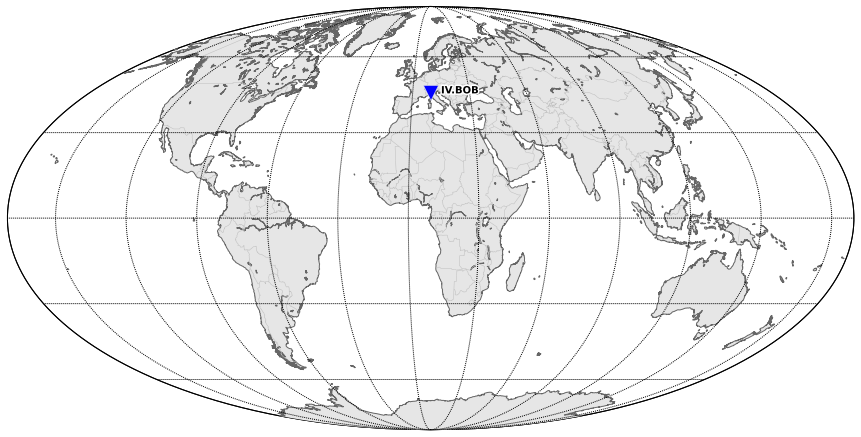

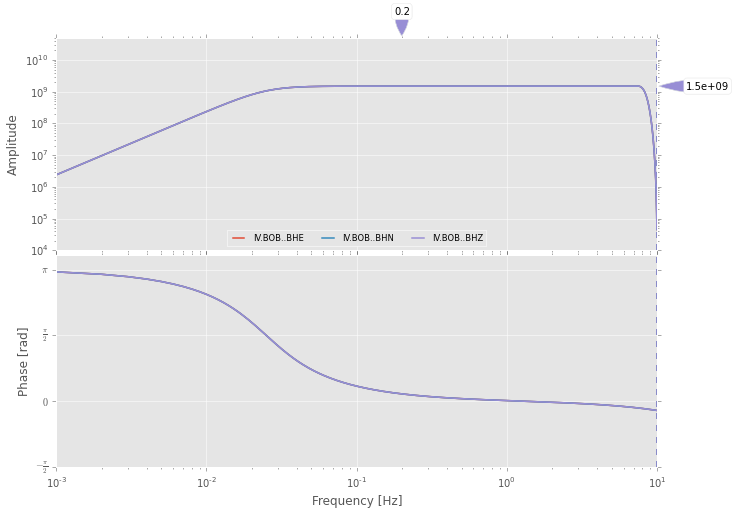

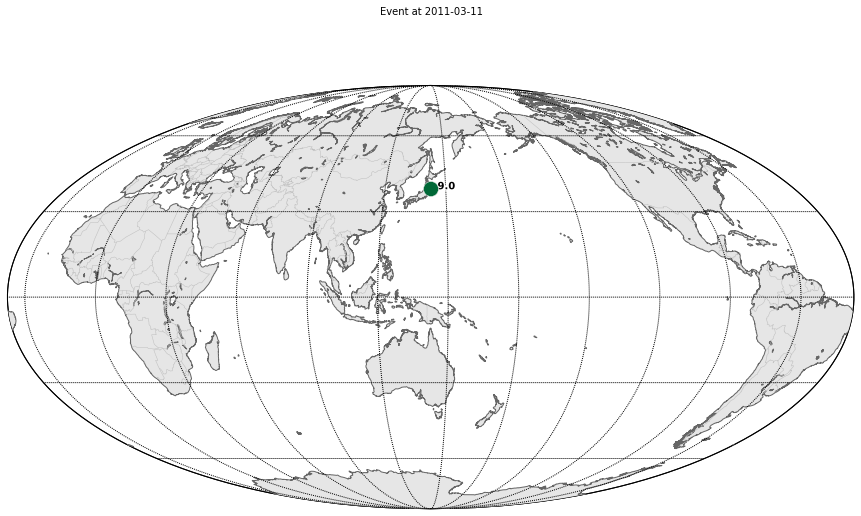

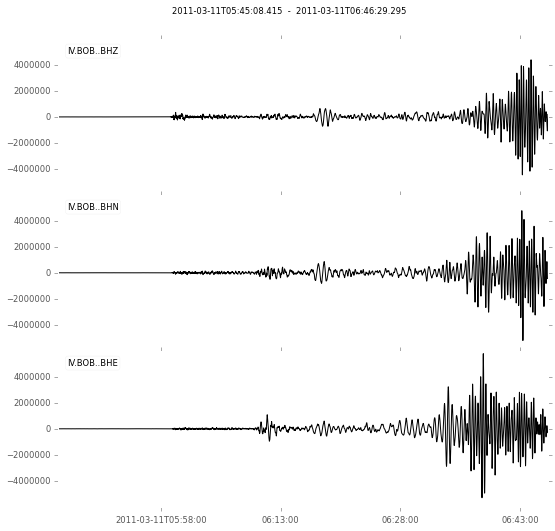

In [3]:
inv.plot()
inv.plot_response(0.001)
cat.plot()
st.plot()

## Exercise

The goal of this exercise is to cut the data from 1 minute before the first arrival to 5 minutes after it, and then remove the instrument response.


#### Step 1: Determine Coordinates of Station

In [4]:
coords = inv.get_coordinates("IV.BOB..BHE")
coords

{'elevation': 910.0,
 'latitude': 44.76792,
 'local_depth': 0.0,
 'longitude': 9.44782}

#### Step 2: Determine Coordinates of Event

In [5]:
origin = cat[0].preferred_origin()
print(origin)

Origin
	       resource_id: ResourceIdentifier(id="smi:webservices.rm.ingv.it/fdsnws/event/1/query?originId=1180759")
	              time: UTCDateTime(2011, 3, 11, 5, 46, 23)
	         longitude: 142.5
	          latitude: 38.3
	             depth: 21000.0
	        depth_type: 'from location'
	         method_id: ResourceIdentifier(id="smi:webservices.rm.ingv.it/fdsnws/event/1/query?methodId=2")
	    earth_model_id: ResourceIdentifier(id="smi:webservices.rm.ingv.it/fdsnws/event/1/query?earthModelId=1")
	           quality: OriginQuality(associated_phase_count=88, used_phase_count=65, associated_station_count=82, used_station_count=65, minimum_distance=0.0, maximum_distance=0.0)
	       origin_type: 'hypocenter'
	   evaluation_mode: 'manual'
	 evaluation_status: 'reviewed'
	     creation_info: CreationInfo(agency_id='INGV', author='CSEM', creation_time=UTCDateTime(2013, 1, 5, 23, 2, 39), version='1000')


#### Step 3: Calculate distance of event and station.

Use `obspy.core.util.geodetics.locations2degree`.

In [6]:
from obspy.core.util.geodetics import locations2degrees

distance = locations2degrees(origin.latitude, origin.longitude,
                             coords["latitude"], coords["longitude"])
print(distance)

86.78313368829718


#### Step 4: Calculate Theoretical Arrivals

```python
from obspy.taup import TauPyModel
m = TauPyModel(model="ak135")
arrivals = m.get_ray_paths(...)
arrivals.plot()
```

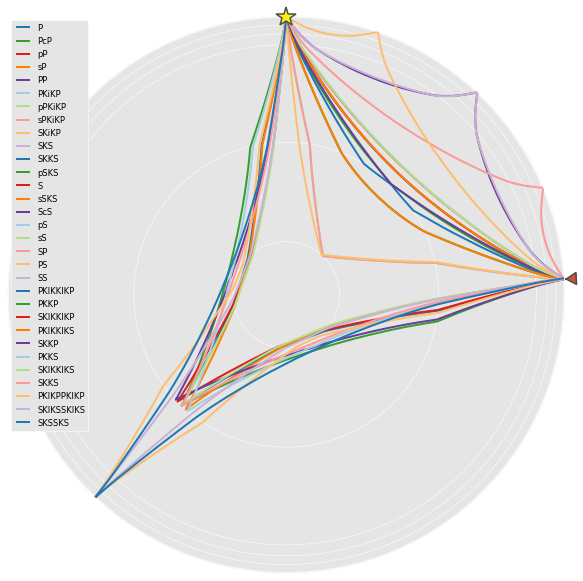

In [7]:
from obspy.taup import TauPyModel

m = TauPyModel(model="ak135")

arrivals = m.get_ray_paths(
    distance_in_degree=distance,
    source_depth_in_km=origin.depth / 1000.0)

arrivals.plot();

#### Step 5: Calculate absolute time of the first arrivals at the station

In [8]:
first_arrival = origin.time + arrivals[0].time

print(first_arrival)

2011-03-11T05:59:05.602076Z


#### Step 6:  Cut to 1 minute before and 5 minutes after the first arrival

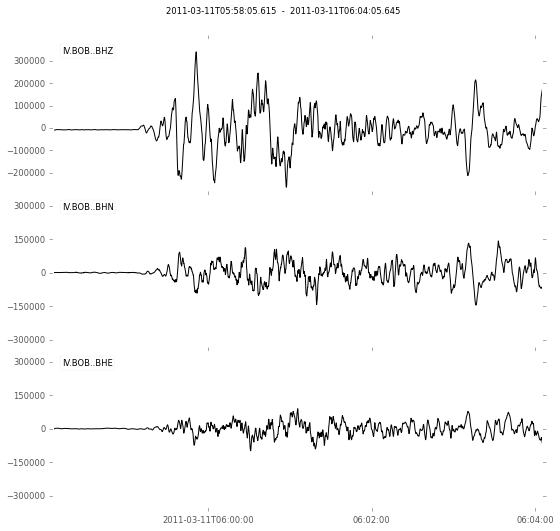

In [9]:
st.trim(first_arrival - 60, first_arrival + 300)
st.plot();

#### Step 7: Remove the instrument response

```python
st.attach_response(inv)
st.remove_response(pre_filt=...)
```

![taper](images/cos_taper.png)

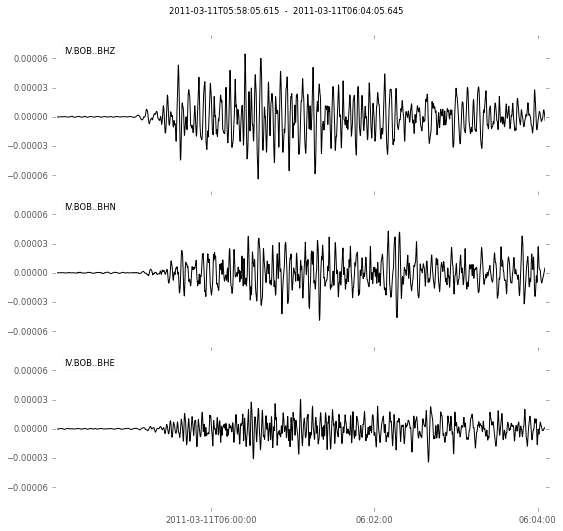

In [10]:
st.attach_response(inv)
st.remove_response(pre_filt=(1.0 / 10.0, 1.0 / 5.0, 1.0, 2.0),
                   output="VEL")
st.plot()

## Bonus: Interactive IPython widgets

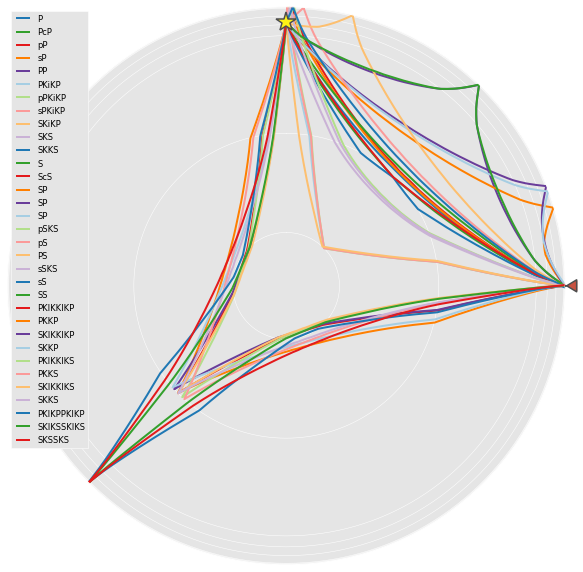

In [11]:
from IPython.html.widgets import interact
from obspy.taup import TauPyModel

m = TauPyModel("ak135")

def plot_raypaths(distance, depth, wavetype):
    try:
        plt.close()
    except:
        pass
    if wavetype == "ttall":
        phases = ["ttall"]
    elif wavetype == "diff":
        phases = ["Pdiff", "pPdiff"]
    m.get_ray_paths(distance_in_degree=distance,
                    source_depth_in_km=depth,
                    phase_list=phases).plot();
    
interact(plot_raypaths, distance=[0, 180],
         depth=[0, 700], wavetype=["ttall", "diff"]);

## Acknowledgements

Background picture at the very top is from Matthias Meschede.